# Report for Isaac Physics

Here is the source code for generating the key conclusions from a statistical analysis of IP. 
The following is included:

* Loading, joining and preparing a subset of the data.
* Creating proxies for IP activity such as 
    * Immersion (ratio of students on platform over students taking Physics exams in 2016)
    * Performance (ratio of correct question attempts for each student taking Physics exams in 2016)
* Determining active and inactive groups according to certain thresholds of activity proxies.
* Determining difference in exam results between active and inactive groups.

## Loading and arranging data

Here we load external and clickstream data, join them and then choose a suitable subset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind,pearsonr, kendalltau, spearmanr
from helper_files import checkLinearFit, test_correlation, sensitivity_on_bin

# Inputs

external_csv = r"/home/andris/GitHub/data/school_ext_data.csv"
internal_csv = r"/home/andris/GitHub/data/school_clk_data.csv"


In [2]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)
print('Total number of schools in external spreadsheet:',len(df_ext))

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)
print('Total number of schools in internal spreadsheet:',len(df_int))

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))
print('Number of schools after joining:',len(df))

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]
print('Number of schools that had all science courses:',len(df))

df.head(5)

Total number of schools in external spreadsheet: 2776
Total number of schools in internal spreadsheet: 1238
Number of schools after joining: 2776
Number of schools that had all science courses: 899


,Entries|2013_Biology,Entries|2013_Chemistry,Entries|2013_Mathematics,Entries|2013_Physics,Entries|2014_Biology,Entries|2014_Chemistry,Entries|2014_Mathematics,Entries|2014_Physics,Entries|2015_Biology,Entries|2015_Chemistry,...,q_lvl_3_std,user_id_std,view_hint_std,q_lvl_1_std,q_lvl_5_cor_std,q_lvl_4_cor_std,q_lvl_1_cor_std,view_concept_std,q_lvl_5_std,play_video_std
URN,,,,,,,,,,,,,,,,,,,,,
100001,19.0,25.0,53.0,17.0,16.0,20.0,41.0,17.0,15.0,14.0,...,170.0,4.0,463.0,6.0,9.0,32.0,48.0,26.0,9.0,41.0
100003,24.0,35.0,77.0,41.0,39.0,37.0,88.0,34.0,26.0,45.0,...,216.0,17.0,628.0,62.0,0.0,0.0,92.0,31.0,0.0,192.0
100054,32.0,21.0,75.0,29.0,34.0,35.0,69.0,21.0,42.0,28.0,...,526.0,17.0,2158.0,169.0,50.0,44.0,109.0,25.0,128.0,438.0
100065,33.0,35.0,70.0,28.0,30.0,34.0,67.0,31.0,25.0,29.0,...,361.0,37.0,1946.0,451.0,26.0,106.0,207.0,41.0,189.0,485.0
100076,10.0,14.0,27.0,11.0,18.0,21.0,32.0,12.0,22.0,20.0,...,0.0,1.0,5.0,0.0,2.0,7.0,0.0,1.0,2.0,1.0


## Choosing activity proxies

Here we choose some proxies for IP activity. 
Further to this, we the improvement in exam score as 

```
exam_improv_year_1-year_2 = (exam_score_year_1 - exam_score_2) - <(exam_score_year_1 - exam_score_2)>
```

This represents improvement in exam score relative to the mean for those years. 

An alternative way of correcting for grade inflation would be to define it as follows

```
exam_improv_year_1-year_2 = (exam_score_year_1 - exam_score_2)/ <(exam_score_year_1 - exam_score_2)>
```

The approach can be chosen bythe user

In [3]:
# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

# Defining it relative to the mean

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]).mean()

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]).mean()

# Defining it as a multiple to the mean

for item in qu:
    df['fmExam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item] - df['exam_score|2013_'+item])/(df['exam_score|2014_'+item] - df['exam_score|2013_'+item]).mean()

for item in qu:
    df['fmExam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2013_'+item])/(df['exam_score|2016_'+item] - df['exam_score|2013_'+item]).mean()
    
# Student activity
df['std_q_cor'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['std_ratio'] =  (df['user_id_std']/df['Entries|2016_Physics']).fillna(0)
df['std_q_cor_alt'] =  (df.filter(regex='_cor_std').sum(axis=1)/df.filter(regex='Entries').sum(axis=1)).fillna(0)
df['std_ratio_alt'] =  (df['user_id_std']/df.filter(regex='Entries').sum(axis=1)).fillna(0)


In [4]:
# ------------------------------------------------------
# Dropping uneeded features
# ------------------------------------------------------

# Remove unneeded clickstream data
df = df.drop(df.filter(regex='_tch|_std').columns,axis=1)
df = df.drop(['view_assig_prog','add_custom_assig','add_assig','create_group','add_user'],axis=1)

# Set all external indices with no value as NULL
df['IDACI'] = df['IDACI'].replace(to_replace=0,value=np.nan)
df['L_M_index'] = df['L_M_index'].replace(to_replace=0,value=np.nan)
df['Effectiveness'] = df['Effectiveness'].replace(to_replace=0,value=np.nan)
df['Teach_quality'] = df['Teach_quality'].replace(to_replace=0,value=np.nan)

# Remove any unecessary features
df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)

## Seperating into active and inactive groups

Here we bin into different groups according to a prescribed threshold of IP activity. 

We have 2 proxies for determing IP activity:

* Performance
* Immersion

First it would be interesting to see how the distribution of schools changes according to these proxies. 
Then we can plot histograms to check out how the active and inactive users may differ. 


In [5]:
# Functions to make the binning easier. 

def bin_groups(df, feature, bins, group_names):
    
    categories = pd.cut(df[feature],bins, labels=group_names)
    return categories

def plotHistograms(feature_list,nrows, ncols, figsize=(20,10)):
    
    
    plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize);

    count = 1;
    for feature in feature_list:
        
        plt.subplot(nrows,ncols,count)
        plt.hist(df[df['categories']=='Inactive'][feature])
        plt.hist(df[df['categories']=='Active'][feature],alpha=0.8)
        plt.xlabel(feature)
        count += 1

In [6]:
# Number of inactive schools

print('Schools with zero immersion:',df[df['std_ratio']==0]['std_ratio'].count())

print('Schools with zero performance:',df[df['std_q_cor']==0]['std_ratio'].count())

Schools with zero immersion: 400
Schools with zero performance: 410


Text(0,0.5,'Number of active schools')

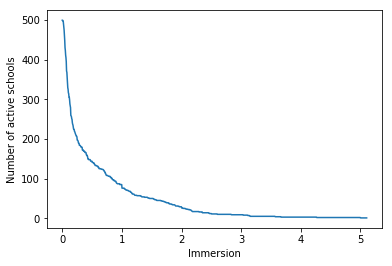

In [7]:
store = [];

for item in range(1000)*max(df['std_ratio'])/1000:                           
    store.append(df[df['std_ratio'] > item]['std_ratio'].count())
    
plt.plot(range(1000)*max(df['std_ratio'])/1000,store)
plt.xlabel('Immersion')
plt.ylabel('Number of active schools')

Text(0,0.5,'Number of active schools')

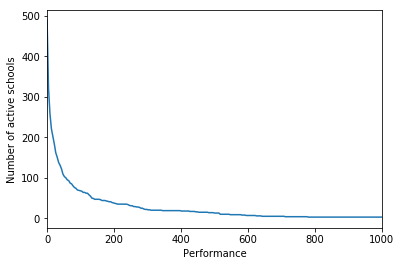

In [8]:
store = [];

for item in range(1000)*max(df['std_q_cor'])/1000:                           
    store.append(df[df['std_q_cor'] > item]['std_q_cor'].count())
    
plt.plot(range(1000)*max(df['std_q_cor'])/1000,store)
plt.xlim([0,1000])
plt.xlabel('Performance')
plt.ylabel('Number of active schools')

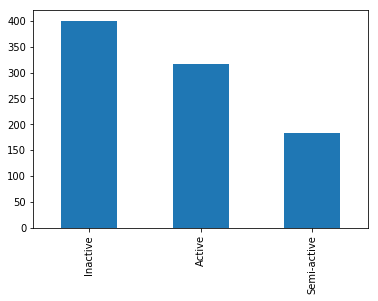

In [19]:
# ------------------------------------------------------
# Binning and displaying the distribution
# ------------------------------------------------------

bins = [-0.1, 0, 0.1,10000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = bin_groups(df,'std_ratio',bins,group_names)

# Plot a histogram
df['categories'].value_counts().plot(kind='bar')
plt.savefig('distribution.png', format='png', dpi=300)


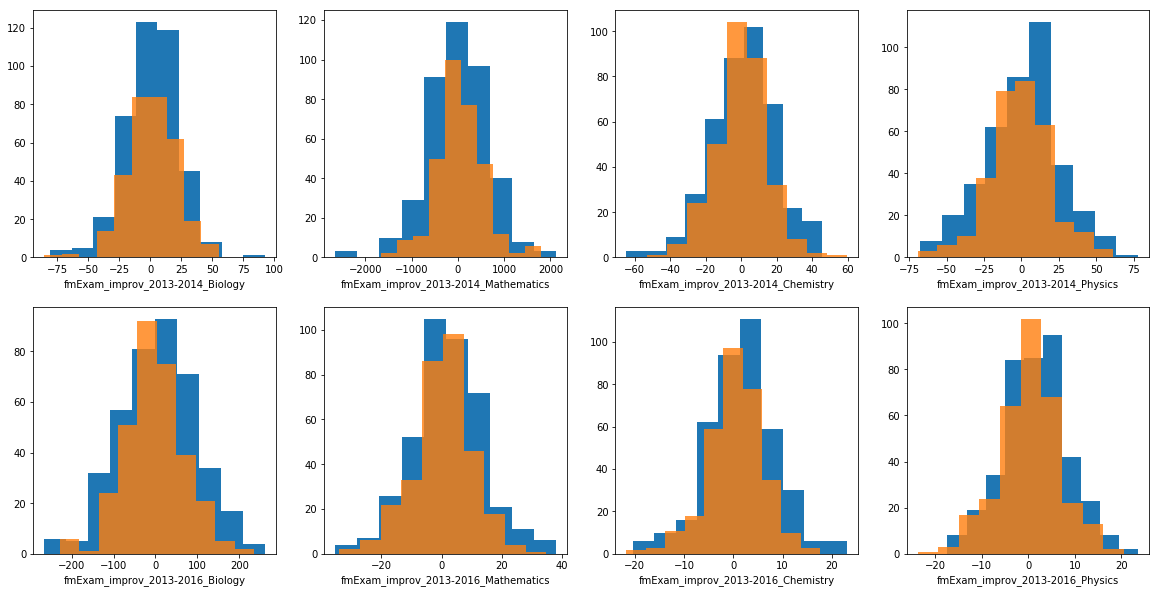

In [10]:
# Checking for distribution of exam imrovement
plotHistograms(df.filter(regex='Exam_improv').columns,2,4)

In [11]:
# Doing an F-test on to check for statistical significance

from sklearn.feature_selection import f_classif

df_test = df[df['categories']!= 'Semi-active']

X = df_test.filter(regex='Exam_improv|exam_improv')
y = [1 if item == 'Active' else 0 for item in df_test['categories']]
F, pval = f_classif(X, y)

df_score = pd.DataFrame({'Key':X.keys(),'F score':F,'p values':pval})

df_score.sort_values('p values')

,F score,Key,p values
15,5.397046,fmExam_improv_2013-2016_Physics,0.020451
7,5.397046,exam_improv_2013-2016_Physics,0.020451
6,4.934415,exam_improv_2013-2016_Chemistry,0.026640
14,4.934415,fmExam_improv_2013-2016_Chemistry,0.026640
5,3.866692,exam_improv_2013-2016_Mathematics,0.049640
13,3.866692,fmExam_improv_2013-2016_Mathematics,0.049640
4,1.917056,exam_improv_2013-2016_Biology,0.166614
12,1.917056,fmExam_improv_2013-2016_Biology,0.166614
1,1.354593,exam_improv_2013-2014_Mathematics,0.244866
9,1.354593,fmExam_improv_2013-2014_Mathematics,0.244866


In [12]:
# Doing a non parametric test, Kolmogorov-Smirnov statisitc


In [13]:
# Looks good, do a sensitivity test to check what value of the cut-off needs investigating
bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,200))*0.01
df_score = sensitivity_on_bin(df, 'std_ratio', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], cut_off_array)

df_score.head(5)

,Cut off,F score,Group_2 - Group_0,Key,Num active,p values
exam_improv_2013-2014_Biology,0.01,0.010987,0.000546,exam_improv_2013-2014_Biology,497,0.916544
exam_improv_2013-2014_Mathematics,0.01,0.612308,0.003607,exam_improv_2013-2014_Mathematics,497,0.434127
exam_improv_2013-2014_Chemistry,0.01,0.286215,0.002832,exam_improv_2013-2014_Chemistry,497,0.592789
exam_improv_2013-2014_Physics,0.01,0.100786,0.002058,exam_improv_2013-2014_Physics,497,0.750962
exam_improv_2013-2016_Biology,0.01,3.510098,0.010527,exam_improv_2013-2016_Biology,497,0.061322


In [14]:
# Looks good, do a sensitivity test to check what value of the cut-off needs investigating
bins = [-0.1, 1, 1000]
cut_off_array = np.array(range(1,200))*0.01
df_score = sensitivity_on_bin(df, 'std_ratio', df.filter(regex='exam_improv').columns, bins, ['Inactive','Active'], cut_off_array)

df_score.head(5)

IndexError: list index out of range

In [ ]:

x_range = np.unique(df_score['Key'])
y_range = ['p values','Group_2 - Group_0']

n_rows = len(x_range)
n_cols = len(y_range)
plt.subplots(n_rows,n_cols, figsize=(10,40))
        

count = 1
for item_x in x_range:
    
    df_test = df_score[df_score['Key'] == item_x]
    for item_y in y_range:

        plt.subplot(n_rows,n_cols,count)
        plt.scatter(df_test['Cut off'],df_test[item_y])
        #plt.plot(df_test['Cut off'], np.ones(len(df_test['Cut off']))*0.05)
        plt.xlabel('Cut off')
        plt.ylabel(item_y)
        plt.title(item_x)
        
        count += 1

In [ ]:
# Looks good, do a sensitivity test to check what value of the cut-off needs investigating
bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,350))*0.0001
df_score = sensitivity_on_bin(df, 'std_q_ratio', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], cut_off_array)

df_score.head(5)

In [ ]:

x_range = np.unique(df_score['Key'])
y_range = ['p values','Group_2 - Group_0']

n_rows = len(x_range)
n_cols = len(y_range)
plt.subplots(n_rows,n_cols, figsize=(10,40))
        

count = 1
for item_x in x_range:
    
    df_test = df_score[df_score['Key'] == item_x]
    for item_y in y_range:

        plt.subplot(n_rows,n_cols,count)
        plt.scatter(df_test['Cut off'],df_test[item_y])
        #plt.plot(df_test['Cut off'], np.ones(len(df_test['Cut off']))*0.05)
        plt.xlabel('Cut off')
        plt.ylabel(item_y)
        plt.title(item_x)
        
        count += 1

In [15]:
# Checking for the first one

bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,500))*0.001
df_score_1 = sensitivity_on_bin(df, 'std_ratio', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], cut_off_array)

# Check for the second one

bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,400))*0.1
df_score_2 = sensitivity_on_bin(df, 'std_q_cor', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], cut_off_array)



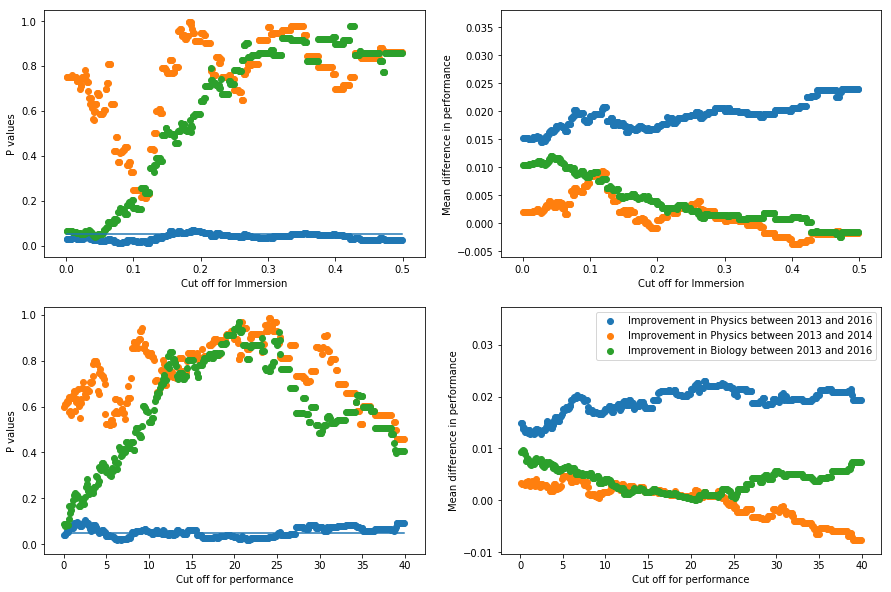

In [20]:
# Plotting

df_test_1a = df_score_1[df_score_1['Key'] == 'exam_improv_2013-2016_Physics']
df_test_1b = df_score_1[df_score_1['Key'] == 'exam_improv_2013-2014_Physics']
df_test_1c = df_score_1[df_score_1['Key'] == 'exam_improv_2013-2016_Biology']


df_test_2a = df_score_2[df_score_2['Key'] == 'exam_improv_2013-2016_Physics']
df_test_2b = df_score_2[df_score_2['Key'] == 'exam_improv_2013-2014_Physics']
df_test_2c = df_score_2[df_score_2['Key'] == 'exam_improv_2013-2016_Biology']

# Creating the subplots
plt.subplots(2,2,figsize=(15,10))

# Plotting
plt.subplot(2,2,1)
plt.scatter(df_test_1a['Cut off'],df_test_1a['p values'])
plt.scatter(df_test_1b['Cut off'],df_test_1b['p values'])
plt.scatter(df_test_1c['Cut off'],df_test_1c['p values'])
plt.plot(df_test_1c['Cut off'],np.ones(len(df_test_1c['p values']))*0.05)
plt.xlabel('Cut off for Immersion')
plt.ylabel('P values')


plt.subplot(2,2,2)
plt.scatter(df_test_1a['Cut off'],df_test_1a['Group_2 - Group_0'])
plt.scatter(df_test_1b['Cut off'],df_test_1b['Group_2 - Group_0'])
plt.scatter(df_test_1c['Cut off'],df_test_1c['Group_2 - Group_0'])
plt.xlabel('Cut off for Immersion')
plt.ylabel('Mean difference in performance')

plt.subplot(2,2,3)
plt.scatter(df_test_2a['Cut off'],df_test_2a['p values'])
plt.scatter(df_test_2b['Cut off'],df_test_2b['p values'])
plt.scatter(df_test_2c['Cut off'],df_test_2c['p values'])
plt.plot(df_test_2c['Cut off'],np.ones(len(df_test_2c['p values']))*0.05)
plt.xlabel('Cut off for performance')
plt.ylabel('P values')

plt.subplot(2,2,4)
plt.scatter(df_test_2a['Cut off'],df_test_2a['Group_2 - Group_0'])
plt.scatter(df_test_2b['Cut off'],df_test_2b['Group_2 - Group_0'])
plt.scatter(df_test_2c['Cut off'],df_test_2c['Group_2 - Group_0'])
plt.xlabel('Cut off for performance')
plt.ylabel('Mean difference in performance')


plt.legend(['Improvement in Physics between 2013 and 2016','Improvement in Physics between 2013 and 2014','Improvement in Biology between 2013 and 2016'])
plt.savefig('improvement in exam.png', format='png', dpi=300)
